In [ ]:
#%%

import torch
import torch.nn as nn
import torch.functional as F
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as lin

In [ ]:
# %%

#first we will generate a random covariance matrix lambda of dimension M

M = 6000
N = 400
sigw2 = 1
sigu2 = 1
sige2 = 0
wiI = torch.normal( torch.zeros((N, M), dtype=torch.float32)  , (sigw2/M)*torch.ones((N, M)) )
uiI = torch.normal( torch.zeros((N, M), dtype=torch.float32)  , (sigu2/M)*torch.ones((N, M)) )
thetaij = torch.randn((N, N),dtype=torch.float32)
R = torch.nn.init.orthogonal_(torch.empty(M, M, dtype=torch.float32))



def gen_Lambda():
    A = torch.randn((M, M))
    return A.transpose(-2, -1) @ A


def gen_Lambda_pow(lminus, alpha):
    spec_vec = torch.tensor([lminus*M**(1+alpha)*(1/i)**(1+alpha) for i in range(1, M+1) ], dtype=torch.float32  )
    spec_vec = spec_vec/max(spec_vec)
    lambda_diag = torch.diag(spec_vec)
    return lambda_diag 

Lambda = gen_Lambda_pow(1, 1)

In [ ]:
#%%

#how to impose that the spectrum is a power law?

#get x will now be based on this Lambda
def get_xI(n_samples):
    dist = torch.distributions.MultivariateNormal(torch.zeros(M, dtype=torch.float32) , Lambda )
    diagsample = dist.sample((n_samples,))
    return torch.einsum('ij,kj->ik', diagsample, R)

def dataset(n_points):
    xIs = get_xI(n_points)
    yis = torch.einsum('ij,kj->ik',  xIs, wiI)+sige2*torch.randn((n_points, N))
    return (xIs, yis)

def phi(xI):
   return torch.einsum('j,kj->k',  xI, uiI)

def zi(xI):
    return torch.einsum('ij,j->i', thetaij, phi(xI))


#as we expect, the number of nonzero eigenvalues is limited by the number of vectors

#now we would like to construct a model for phi which we will train.
#The solution to the regularized porblem is known analytically as this is the classic
#problem in multiple regression 

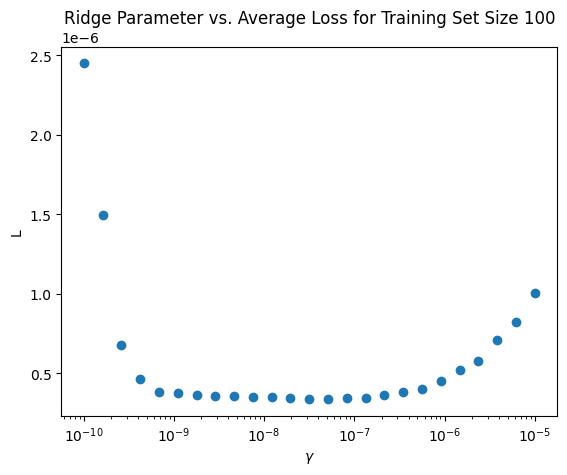

In [ ]:
# %%

#let's plot test loss as a function of ridge parameter in order to explore this

That = 1000

def loss_data(T, gamma):
    xIs, yis = dataset(T)
    xIhats, yihats = dataset(That)
    phis = torch.stack([phi(xI) for xI in xIs])

    def qij(gamma):
        return torch.linalg.inv(gamma*torch.diag(torch.ones((N,)))+ phis.transpose(-2, -1) @ phis)

    def thetaijst(gamma):
        qq = qij(gamma)
        return torch.einsum('ai, jk, ak -> ij', yis, qq, phis)

    theta_star = thetaijst(gamma)

    def zist(xI):
        return torch.einsum('ij,j->i', theta_star, phi(xI))


    zsts =  torch.stack([zist(xIhat) for xIhat in xIhats])
    loss = sum( [sum([x.item()**2 for x in zsts[i]-yihats[i] ]  ) for i in range(That)])/That
    return loss


T = 100
gamma_data = []
losses = []
for gamma in torch.logspace(-10, -5, 25):
    gamma_data.append(gamma)
    loss = loss_data(T, gamma)
    losses.append(loss)

plt.semilogx(gamma_data, losses, 'o')
plt.title("Ridge Parameter vs. Average Loss for Training Set Size 100")
plt.xlabel("$\gamma$")
plt.ylabel("L")
plt.show()

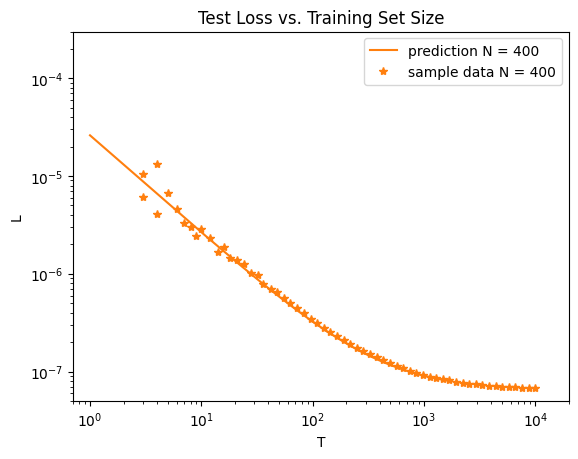

In [ ]:
# %%

#Now we put in the optimal ridge parameter by hand and plot versus data set size

gamma = 1e-7
That = 1000

def loss_data(T):
    xIs, yis = dataset(T)
    xIhats, yihats = dataset(That)
    phis = torch.stack([phi(xI) for xI in xIs])

    def qij(gamma):
        return torch.linalg.inv(gamma*torch.diag(torch.ones((N,)))+ phis.transpose(-2, -1) @ phis)

    def thetaijst(gamma):
        qq = qij(gamma)
        return torch.einsum('ai, jk, ak -> ij', yis, qq, phis)

    theta_star = thetaijst(gamma)

    def zist(xI):
        return torch.einsum('ij,j->i', theta_star, phi(xI))


    zsts =  torch.stack([zist(xIhat) for xIhat in xIhats])
    loss = sum( [sum([x.item()**2 for x in zsts[i]-yihats[i] ]  ) for i in range(That)])/That
    return loss

losses = []
T_data = []
for x in torch.logspace(1/2, 4, 60, base= 10):
    T = int(x.item())
    T_data.append(T)
    loss = loss_data(T)
    losses.append(loss)


powerxs = np.arange(1, 1600, 10)
powerys = [2.6e-5*(1/x+ 1/N) for x in powerxs]
plt.loglog(powerxs, powerys, color = 'tab:orange')
plt.loglog(T_data, losses, '*', color='tab:orange')



plt.xlim((7e-1, 2e4))
plt.ylim((5e-8, 3e-4))
plt.title("Test Loss vs. Training Set Size")
plt.xlabel("T")
plt.ylabel("L")
plt.legend(["prediction N = 400", "sample data N = 400", "prediction N = 100", "sample data N ="])
plt.show()